Part 1: Get the wine dataset

*Describe data set

In [155]:
# Split data into training and test set
import numpy as np
import pandas as pd

df = pd.read_csv('wine\wine.csv')
print("Total rows: ", len(df))
# print(df)

# wine = np.array(df)
# print(wine)

train_idxs = np.random.choice(range(len(df)), size=int(0.8*len(df)))
print(train_idxs)
train = df.iloc[train_idxs]
print("Training set rows: ",len(train))

test_idxs = np.full(len(df), True)
test_idxs[train_idxs] = False
test = df.iloc[test_idxs]
print("Test set rows: ",len(test))

train.to_csv('wine-train.csv')
test.to_csv('wine-test.csv')


Total rows:  177
[ 96  40 140 154  24 169  76 139  39 102   1  53  85 155  11  86 120 158
  41  83 169  54  45  90 133  35  63  69  74 153 172 150  26  38 165 171
   5 153 132  97  16 145  42   5  49  11  16 164 116  17  98 125 140  80
  70  92  52  15  31  80  31 176 116  12  14  80  98  65  11   7  35  78
  38  23  79 126 137  76  47  96  20  66 171  46   5  56 100  68   9 104
  24   3 165 112  15 176  85 172 120   7  27 138  92  14  39  39 123   0
  58  61 147  56 158 174 125  75  83  96 127  71  56  34  15  36 122  44
  92 161 105  21 152  55  58 163 170  97 154 107  43  28 141]
Training set rows:  141
Test set rows:  77


In [156]:
# Split training data into training and cross validation sets
from sklearn.model_selection import train_test_split
from collections import Counter

df_train = pd.read_csv('wine-train.csv')
train = np.array(df_train, dtype=float)

train, valid = train_test_split(train, shuffle=True)

# Split test and validation data into X and Y (inputs and labels)
train_y, train_X, valid_y, valid_X = train[:, 1], train[:, 2 : ], valid[:, 1], valid[:, 2 : ] # The labels are in column number 2, the Xs are column 3 onwards

# Split test data into X and Y (inputs and labels)
test = np.array(pd.read_csv('wine-test.csv'))
test_y, test_X = test[:, 1], test[:, 2 : ]
test_y = np.array(test_y, int)
print(test_y)
# Look at the balance of classes to make sure that evaluating models on just their accuracy is okay
print(Counter(test_y))
print(Counter(train_y))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3]
Counter({2: 35, 3: 23, 1: 19})
Counter({1.0: 40, 2.0: 38, 3.0: 27})


Part 2: Fit models to the wine dataset and test performance

Using a classification tree on the model. Evaluate the model's performance by comparing its predicted labels with the test labels using accuracy (the fraction of the predictions that were correct).


In [157]:
# run a classification tree on the dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier()
tree.fit(test_X, test_y)

# Evaluate performance on cross validation set
pred_y = tree.predict(valid_X)
print(accuracy_score(valid_y, pred_y))

# Evaluate performance by comparing with test data
pred_y = tree.predict(test_X)
print(accuracy_score(test_y, pred_y))


1.0
1.0


Part 3: Ensembling to improve performance

Ensemble the classification tree model used above buy using random forests. Evaluate model by looking at its accuracy. 

In [158]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=100, max_depth=2, max_samples=10)
randomForest.fit(train_X, train_y) # fit random forest of decision trees

# Evaluate the ensemble's performance
score = randomForest.score(test_X, test_y) # use the model's score method to compute it's accuracy
print(score)



0.961038961038961


Part 4: Finding the best models and hyperparameters

We have used the following models for supervised learning classification problems so far: Logistic Regression, RandomForests, Support Vector Machines, and K nearest-neighbours. Using sklearn's VotingClassifier, we can ensemble different models and using sklearn's accuracy_score, we can compare the accuracies to find the best single model, or ensemble of models. 

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from numpy import random
import itertools


def update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model):
    # A function to see if this current model gives a better accuracy than any previous models, and then to update the new best model
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    accuracy = accuracy_score(test_y, pred_y) # If this accuracy is highest so far, then update the best model with this model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    return best_accuracy, best_model

def parameter_search(model_name, train_X, train_y, test_X, test_y,  estimators=[], n_samples=100,):
            """
            Hyperparameter search function.

            Finds the best parameters of a given model based on whichever parameters give the highest accuracy score.
            Works with the following scikit-learn models: RandomForestClassifier, LogisticRegression, SVC and KNeighborsClassifier.

            Parameters 

            model_name:{"RandomForestClassifier", "LogisticRegression", "SVC", "KNeighborsClassifier"}
                Depending on the model chosen, different hyperparameters will be returned. 
                For "RandomForestClassifier", the n_estimators, max_depth and max_samples will be returned
                For "LogisticRegression", the C will be returned
                For "SVC", the C and gamma will be returned
                For "KNeighborsClassifier", the n_neighbours will be returned.

            train_X, train_y, test_X, test_y: numpy array
                This will take in the training data and test data in the order of the training Xs then ys, then the test Xs then ys.

            n_samples: int, default=1000
                How many samples of each hyperparameter are required, meaning a total of (n_samples**number of hyperparameters) samples will be taken.

            """
            # Initialise best accuracy and best model variables
            best_accuracy = 0
            best_model = None

            # Search for different parameteres depending on the model
            if model_name == "RandomForestClassifier":
                for i in range(1, min(len(train_X), n_samples) + 1): # There can't be more samples than there are examples in data
                    for j in range(1, 5): # Trees should remain short in random forests
                        model = RandomForestClassifier(max_samples=i,max_depth=j)
                        best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            elif model_name in ["LogisticRegression","SVC"]:
                half = int(n_samples/2)
                C = random.exponential(scale=1, size=(half)) # let half of the values for C be small (roughly between 0 and 1)
                C = np.append(C, 10*random.exponential(scale=100, size=(n_samples-half))) # let other half be big (roughly between 10 and 10000)
                for c in C:
                    if model_name == "LogisticRegression":
                        model = LogisticRegression(C=c)
                        best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
                    else:
                        for g in C:
                            model = SVC(C=c, gamma=g)
                            best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            elif model_name == "KNeighborsClassifier":
                for i in range(1, min(len(train_X), n_samples) + 1): # There can't be more neighbours than there are examples in the data
                    # Initialise and test the model on these parameters
                    model = KNeighborsClassifier(n_neighbors=i)
                    best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            elif model_name == "VotingClassifier":
                total_combs_of_estimators = []
                for i in range(2, len(estimators) + 1): # get all the different combinations of the models for ensembling
                    total_combs_of_estimators.extend(list(itertools.combinations(estimators, i)))
                for estimator in total_combs_of_estimators:
                    model = VotingClassifier(estimators=estimator, voting='hard')
                    best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
            else:
                print("Please check the documentation and specify a relevant model")
                return
            print("The best parameters have been found for", best_model.__class__.__name__, "with an accuracy of", best_accuracy, "on the cross validation data, with parameters:",best_model.get_params(),"\n")
            return best_model 



def BestModelAndParameter(train_X, train_y, valid_X, valid_y, test_X, test_y, n_samples=100):
    
    # initialise every model with their best parameters, using VALIDATION data not test data
    ran_for = parameter_search("RandomForestClassifier",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    log_reg = parameter_search("LogisticRegression",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    sup_vec = parameter_search("SVC",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    K_near = parameter_search("KNeighborsClassifier",train_X, train_y, valid_X, valid_y, n_samples=n_samples)
    
    estimators=[('rf', ran_for), ('lr', log_reg), ('svc', sup_vec), ('Knear', K_near)]
    voting = parameter_search("VotingClassifier",train_X, train_y, valid_X, valid_y,estimators=estimators)

    best_accuracy = 0
    best_model = None
    for model in (ran_for, log_reg, sup_vec, K_near, voting):
        best_accuracy, best_model = update_best_model(model, train_X, train_y, test_X, test_y, best_accuracy, best_model)
        print("On the training data, model", model.__class__.__name__, "has an accuracy of:", accuracy_score(test_y, model.predict(test_X)))
    print("\nTherefore, the best model was", best_model.__class__.__name__, "with an accuracy of", best_accuracy)
    print("\nThis model has the following parameters:", best_model.get_params())
    return best_model

model = BestModelAndParameter(train_X, train_y, valid_X, valid_y, test_X, test_y, 150)


The best parameters have been found for RandomForestClassifier with an accuracy of 1.0 on the cross validation data, with parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 3, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 

The best parameters have been found for LogisticRegression with an accuracy of 0.9166666666666666 on the cross validation data, with parameters: {'C': 0.8565666086900728, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

The best p

Part 5: Present your results

1. It is clear that using the aboth three functions we can have the optimal model returned, ready loaded with the optimal parameters. The results of this final model are shown on the graph below.

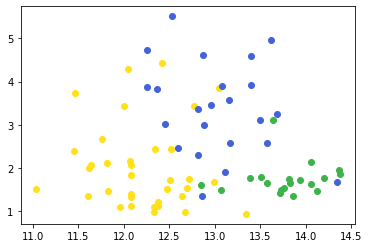

ValueError: X has 2 features per sample; expecting 13

In [160]:
import sys
sys.path.append('..')
from utils import get_classification_data, show_data, visualise_predictions, colors

accuracy_score(model.predict(test_X), test_y)
show_data(test_X, test_y)
visualise_predictions(model.predict, test_X, test_y)

Part 5 (continued):

2. It seems that K-nearest neighbours consintently performs the worst, with support vector machines coming in second worst. Looking at their performance on the validation data however, it seems that they can achieve accuracies near 90%, which means that these models are overfitting to the training dataand failing to generalise to new examples. Even with the validation data, K-nearest neighbours performs the worst, and this may be due to the nature of data. K-nearest works best with data that is in clear clusters, but from the graph above, there seems to be a decent amount of mix-up between clusters. Logistic Regression and Random Forests seem to be performing the best on the data, sugessting that the data is more suited for them.

3. The best permutation found was Logistic Regression with an accuracy of 93.5% and a C parameter value of 0.8565666086900728 using the L2 norm. Since larger values of C indicate weaker regularistion, a value slightly below 1 suggests a slightly strong use of regularistion was the best. This model generalises very well, as it had a higher accuracy on the test data than on the validation data, whereas other models like Random Forests had a perfect accuracy on the validation data but much lower accuracy on test data. This suggested a good balance between variance and bias with this Logistic Regression model.

Part 6: "A stakeholder asks you which features most affect the response variable (output). Describe how you would organise a test to determine this."

I would test this by manipulating the input data for the models, such that all the Xs for one feature are set to zero, and then repeating this until every feature has had a chance to be set to zero. I would then compare which result ends up with the biggest difference from the original result which had all features included. This feature when set to zero that correspends to the biggest difference would therefore be the feature that has the greatest influence over the response variable. 